In [1]:
# To support both python 2 and python 3
# 让这份笔记同步支持 python 2 和 python 3
from __future__ import division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [2]:
#使用statsmodels便于统计分析数据
import statsmodels.api as sm
import statsmodels.formula.api as smf
#使用sklearn便于预测（机器学习）
from sklearn import linear_model
#使用patsy便于生成模型
import patsy

**9. This problem involves the OJ data set which is part of the ISLR
package.
(a) Create a training set containing a random sample of 800 obser-
vations, and a test set containing the remaining observations.**

In [3]:
OJ = pd.read_csv("data/OJ.csv").dropna().drop('Unnamed: 0',axis = 1)
OJ.head()

,Purchase,WeekofPurchase,StoreID,PriceCH,PriceMM,DiscCH,DiscMM,SpecialCH,SpecialMM,LoyalCH,SalePriceMM,SalePriceCH,PriceDiff,Store7,PctDiscMM,PctDiscCH,ListPriceDiff,STORE
0,CH,237,1,1.75,1.99,0.00,0.0,0,0,0.500000,1.99,1.75,0.24,No,0.000000,0.000000,0.24,1
1,CH,239,1,1.75,1.99,0.00,0.3,0,1,0.600000,1.69,1.75,-0.06,No,0.150754,0.000000,0.24,1
2,CH,245,1,1.86,2.09,0.17,0.0,0,0,0.680000,2.09,1.69,0.40,No,0.000000,0.091398,0.23,1
3,MM,227,1,1.69,1.69,0.00,0.0,0,0,0.400000,1.69,1.69,0.00,No,0.000000,0.000000,0.00,1
4,CH,228,7,1.69,1.69,0.00,0.0,0,0,0.956535,1.69,1.69,0.00,Yes,0.000000,0.000000,0.00,0


In [4]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(OJ, train_size = 800, random_state = 1)

**(b) Fit a tree to the training data, with Purchase as the response
and the other variables as predictors. Use the summary() function
to produce summary statistics about the tree, and describe the
results obtained. What is the training error rate? How many
terminal nodes does the tree have?**

In [5]:
columns = '1'
for column in OJ.columns:
    columns = columns + '+' + column
y_test,X_test = patsy.dmatrices('Purchase ~ {} - Purchase'.format(columns), test_set, return_type = 'dataframe')
y_train,X_train = patsy.dmatrices('Purchase ~ {} - Purchase'.format(columns), train_set, return_type = 'dataframe')
X_train.drop('Intercept',axis = 1,inplace= True)
X_test.drop('Intercept',axis = 1,inplace= True)

In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
tree_clf = DecisionTreeClassifier(random_state = 1)
tree_clf.fit(X_train,y_train['Purchase[CH]'])
print(classification_report(y_train['Purchase[CH]'], tree_clf.predict(X_train)))

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99       304
         1.0       1.00      0.99      0.99       496

    accuracy                           0.99       800
   macro avg       0.99      0.99      0.99       800
weighted avg       0.99      0.99      0.99       800



In [7]:
1 - accuracy_score(y_train['Purchase[CH]'],tree_clf.predict(X_train))

0.010000000000000009

In [8]:
#实际的Number of terminal nodes
(tree_clf.tree_.children_left == -1).sum()

165

In [9]:
#对应Residual mean deviance :
ysample_1 = tree_clf.tree_.value[:,0][:,0]
ysample_2 = tree_clf.tree_.value[:,0][:,1]
yprob_1 = tree_clf.tree_.value[:,0][:,0]/(tree_clf.tree_.value[:,0][:,0] + tree_clf.tree_.value[:,0][:,1])
yprob_2 = tree_clf.tree_.value[:,0][:,1]/(tree_clf.tree_.value[:,0][:,0] + tree_clf.tree_.value[:,0][:,1])
y_1_index = (tree_clf.tree_.children_left == -1) & (yprob_1 != 0)
y_2_index = (tree_clf.tree_.children_left == -1) & (yprob_2 != 0)
deviance_compute = -2 * (np.sum(ysample_1[y_1_index] * np.log(yprob_1[y_1_index])) 
                               + np.sum(ysample_2[y_2_index] * np.log(yprob_2[y_2_index])))
print('Residual mean deviance : {:.4f} = {:.1f} / (800-163)'.format(deviance_compute/(800-163),deviance_compute))

Residual mean deviance : 0.0381 = 24.3 / (800-163)


**(c) Type in the name of the tree object in order to get a detailed
text output. Pick one of the terminal nodes, and interpret the
information displayed.**

In [10]:
n_nodes = tree_clf.tree_.node_count
children_left = tree_clf.tree_.children_left
children_right = tree_clf.tree_.children_right
feature = tree_clf.tree_.feature
threshold = tree_clf.tree_.threshold
samples_num = tree_clf.tree_.n_node_samples
yprob_1 = tree_clf.tree_.value[:,0][:,0]/(tree_clf.tree_.value[:,0][:,0] + tree_clf.tree_.value[:,0][:,1])
yprob_2 = tree_clf.tree_.value[:,0][:,1]/(tree_clf.tree_.value[:,0][:,0] + tree_clf.tree_.value[:,0][:,1])
node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, -1)] # seed is the root node id and its parent depth
while len(stack) > 0:
    node_id, parent_depth = stack.pop()
    node_depth[node_id] = parent_depth + 1
    # If we have a test node
    if (children_left[node_id] != children_right[node_id]):
        stack.append((children_left[node_id], parent_depth + 1))
        stack.append((children_right[node_id], parent_depth + 1))
    else:
        is_leaves[node_id] = True
print("The binary tree structure has %s nodes and has ""the following tree structure:"% n_nodes)

for i in range(n_nodes):
    if is_leaves[i]:
        print("%snode=%s leaf node n = %s prob = (%s %s)." % (node_depth[i]*"\t",
                                                              i,
                                                             samples_num[i],
                                                             yprob_1[i].round(3),
                                                             yprob_2[i].round(3)))
    else:
        print("%snode=%s test node n = %s prob = (%s %s): go to node %s if %s <= %s else to "
            "node %s."
            % (node_depth[i]*"\t",
            i,
            samples_num[i],
            yprob_1[i].round(3),
            yprob_2[i].round(3),
            children_left[i],
            X_train.columns[feature[i]],
            threshold[i],
            children_right[i],
            ))
print()

The binary tree structure has 329 nodes and has the following tree structure:
node=0 test node n = 800 prob = (0.38 0.62): go to node 1 if LoyalCH <= 0.45392000675201416 else to node 140.
	node=1 test node n = 289 prob = (0.768 0.232): go to node 2 if LoyalCH <= 0.2761415094137192 else to node 51.
		node=2 test node n = 168 prob = (0.887 0.113): go to node 3 if LoyalCH <= 0.05132499895989895 else to node 10.
			node=3 test node n = 71 prob = (0.986 0.014): go to node 4 if StoreID <= 2.5 else to node 9.
				node=4 test node n = 13 prob = (0.923 0.077): go to node 5 if LoyalCH <= 0.0031299999682232738 else to node 8.
					node=5 test node n = 4 prob = (0.75 0.25): go to node 6 if LoyalCH <= 0.0014194999821484089 else to node 7.
						node=6 leaf node n = 3 prob = (1.0 0.0).
						node=7 leaf node n = 1 prob = (0.0 1.0).
					node=8 leaf node n = 9 prob = (1.0 0.0).
				node=9 leaf node n = 58 prob = (1.0 0.0).
			node=10 test node n = 97 prob = (0.814 0.186): go to node 11 if WeekofPurch

如node=6如果在LoyalCH <= 0.45392000675201416/LoyalCH <= 0.2761415094137192/LoyalCH <= 0.05132499895989895/StoreID <= 2.5/LoyalCH <= 0.0031299999682232738/  LoyalCH <= 0.0014194999821484089情况下Purchase非CH（即为MM），上述条件可压缩为 LoyalCH <= 0.0014194999821484089/StoreID <= 2.5/WeekofPurchase <= 269.5

**(d) Create a plot of the tree, and interpret the results.**

c:\users\wujiaxu\appdata\local\programs\python\python37\lib\site-packages\sklearn\externals\six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


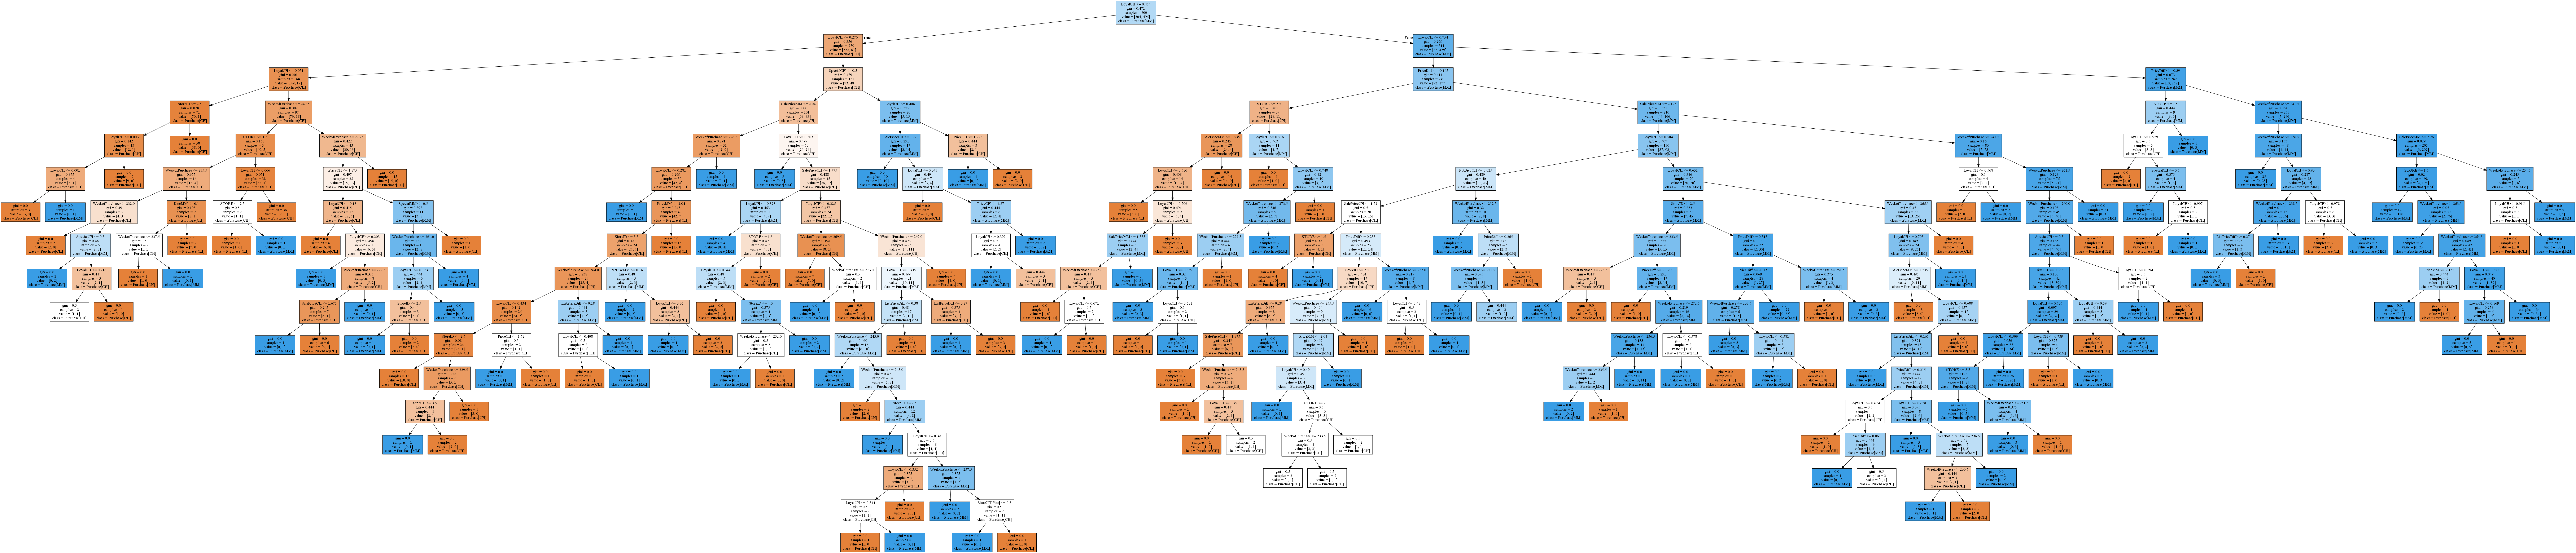

In [11]:
from sklearn.externals.six import StringIO 
from sklearn.tree import export_graphviz
from IPython.display import Image
import pydot
# This function creates images of tree models using pydot
def print_tree(estimator, features, class_names=None, filled=True):
    tree = estimator
    names = features
    color = filled
    classn = class_names
    
    dot_data = StringIO()
    export_graphviz(estimator, out_file=dot_data, feature_names=features, class_names=classn, filled=filled)
    graph = pydot.graph_from_dot_data(dot_data.getvalue())
    return(graph)
graph1, = print_tree(tree_clf, features=X_train.columns, class_names=y_train.columns)
Image(graph1.create_png())

对PYTHON未修剪的树图终端结点（树叶）基本只有很少的样点


**(e) Predict the response on the test data, and produce a confusion
matrix comparing the test labels to the predicted test labels.
What is the test error rate?**

In [12]:
from sklearn.metrics import confusion_matrix
tree_pred = tree_clf.predict(X_test)
confusion_matrix(y_test['Purchase[CH]'],tree_pred)
#python生成的是[['TN','FP']['FN','TP']],与R互倒
tree_pred_table = pd.DataFrame(confusion_matrix(y_test['Purchase[CH]'],tree_pred).T,
                             index = ['MM','CH'],
                             columns = [['Purchase.test','Purchase.test'],['MM','CH']])
tree_pred_table.columns.names = ['','tree.pred']
tree_pred_table       

Purchase.test     
tree.pred            MM   CH
MM                   72   25
CH                   41  132

In [13]:
1 - accuracy_score(y_test['Purchase[CH]'],tree_clf.predict(X_test))

0.24444444444444446

**(f) Apply the cv.tree() function to the training set in order to
determine the optimal tree size.**

In [14]:
from sklearn.model_selection import GridSearchCV
tree_size_range = np.arange(2,(tree_clf.tree_.children_left == -1).sum() + 1)
param_grid = {'max_leaf_nodes':tree_size_range}
tree_clf_grid = DecisionTreeClassifier(random_state = 1)
grid_search = GridSearchCV(tree_clf_grid, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train,y_train['Purchase[CH]'])

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=1, splitter='best'),
             iid='depre...
        93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
       106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,


**(g) Produce a plot with tree size on the x-axis and cross-validated
classification error rate on the y-axis.**

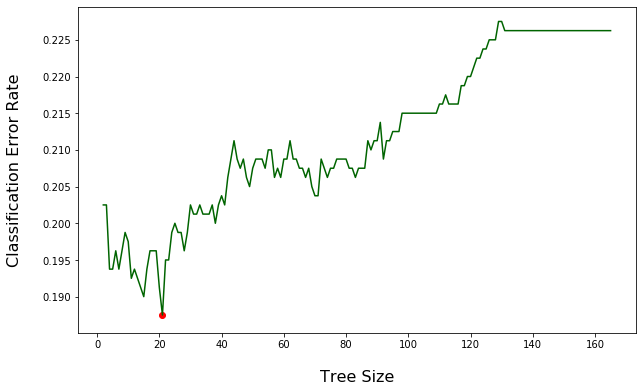

In [15]:
plt.figure(figsize=(10,6))
plt.plot(tree_size_range,1 - grid_search.cv_results_["mean_test_score"],color = 'darkgreen')
plt.scatter(grid_search.best_params_['max_leaf_nodes'],1 - grid_search.best_score_, color = 'red')
plt.xlabel('Tree Size', fontsize = 16,labelpad =20)
plt.ylabel('Classification Error Rate', fontsize = 16,labelpad =20)
plt.show()

**(h) Which tree size corresponds to the lowest cross-validated classi-
fication error rate?**

In [16]:
grid_search.best_params_

{'max_leaf_nodes': 21}

**(i) Produce a pruned tree corresponding to the optimal tree size
obtained using cross-validation. If cross-validation does not lead
to selection of a pruned tree, then create a pruned tree with five
terminal nodes.**

In [17]:
tree_clf_pruned = DecisionTreeClassifier(random_state = 1,max_leaf_nodes = 21)
tree_clf_pruned.fit(X_train,y_train['Purchase[CH]'])

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=21,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1, splitter='best')

**(j) Compare the training error rates between the pruned and un-
pruned trees. Which is higher?**

In [18]:
print('剪枝前训练错误率：',1 - accuracy_score(y_train['Purchase[CH]'],tree_clf.predict(X_train)))
print('剪枝后训练错误率：',1 - accuracy_score(y_train['Purchase[CH]'],tree_clf_pruned.predict(X_train)))

剪枝前训练错误率： 0.010000000000000009
剪枝后训练错误率： 0.125


剪枝后的训练错误率更高

**(k) Compare the test error rates between the pruned and unpruned
trees. Which is higher?**

In [19]:
print('剪枝前测试错误率：',1 - accuracy_score(y_test['Purchase[CH]'],tree_clf.predict(X_test)))
print('剪枝后测试错误率：',1 - accuracy_score(y_test['Purchase[CH]'],tree_clf_pruned.predict(X_test)))

剪枝前测试错误率： 0.24444444444444446
剪枝后测试错误率： 0.20370370370370372


剪枝后测试错误率更低